![](images/waste_classification.jpg)
    Image from [this article](https://www.usnews.com/news/world-report/articles/2019-05-28/malaysia-to-ship-plastic-trash-back-to-the-us-other-origin-countries)

# Problem Statement
In 2017 China stopped accepting recycled material with less than 99.5% purity.  At that point many of our recyclables started making their way to South East Asia and Africa where they are dumped or burned rather than recycled causing health and environmental problems in those regions.

To solve this we need an array of strategies to increase the purity of our sorted recyclables.

The project is an exploration of using deep neural networks for classification of waste images using the Azure's python sdk and the resources of the Microsoft Azure Machine Learning Studio.

# Import Data

The data for this project consists of 2272 images from research by [Mindy Yang](http://github.com/yangmindy4) and [Gary Thung](https://github.com/garythung/) for their paper [Classification of Trash for Recyclability Status](http://cs229.stanford.edu/proj2016/report/ThungYang-ClassificationOfTrashForRecyclabilityStatus-report.pdf).  The images can be downloaded in both their original size and the downsampled sizes [from this google dirve folder](https://drive.google.com/drive/folders/0B3P9oO5A3RvSUW9qTG11Ul83TEE) and are also available on [kaggle.](https://www.kaggle.com/asdasdasasdas/garbage-classification)

The data is also available on kaggle [here](https://www.kaggle.com/asdasdasasdas/garbage-classification)

In [1]:
# imports
import os
import shutil

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, 
                                                  img_to_array, 
                                                  load_img)

from azureml.core import Workspace, Dataset, ScriptRunConfig, Experiment
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import AmlCompute, ComputeTarget

from utils import count_files

In [2]:
# view categories
categories = os.listdir('data/raw')
categories

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [3]:
# count the number of images in each category
image_paths = {}
for cat in categories:
    image_paths[cat] = os.listdir(os.path.join('data/raw',cat))
    print('There are', len(os.listdir(os.path.join('data/raw',cat))), 
          cat, 
          'images' )
    

There are 594 paper images
There are 410 metal images
There are 403 cardboard images
There are 137 trash images
There are 501 glass images
There are 482 plastic images


This dataset is small is fairly small.  Lets take a look at what it contains.

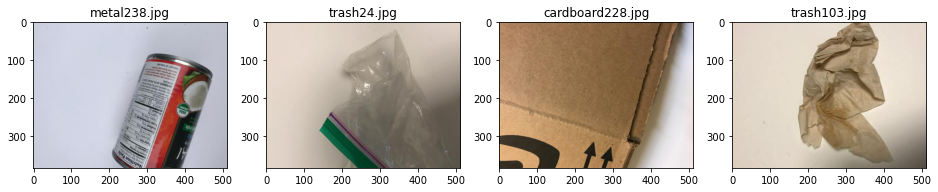

In [4]:
# inspect random images
fig, axs = plt.subplots(1,4, figsize=(16,4))
                        
for ax in axs:
    # choose a random category
    cat = np.random.choice(categories)
    
    # choose a random image in that category
    file_name = np.random.choice(os.listdir(os.path.join('data/raw',cat)))
    
    # load and display the image
    img = load_img(os.path.join('data/raw',cat,file_name))
    ax.imshow(img)
    ax.set_title(file_name)

# Split into train, validation, test

In [5]:
# set proportion of each class to hold for validation and testing.
val_portion = 0.05
test_portion = 0.05

split_base = 'data/split'

# remove the folder if it exists and rerun the split
if os.path.isdir(split_base):
    shutil.rmtree(split_base)

os.mkdir(split_base)

# store the path of each folder and create directories
train_folder = os.path.join(split_base, 'train')
os.mkdir(train_folder)

val_folder = os.path.join(split_base, 'validation')
os.mkdir(val_folder)

test_folder = os.path.join(split_base, 'test')
os.mkdir(test_folder)



In [6]:
# Split the data into training, validation, and split folders
for cat in categories:
    # get total number of files in this category
    num_files = len(image_paths[cat])
    
    # randomize the file order for this category
    np.random.shuffle(image_paths[cat])
    
    # set split boundries for validation and test
    validation_boundry = int(np.floor(num_files * val_portion))
    test_boundry = int(np.floor(num_files * test_portion) + validation_boundry)
        
    # store boundries
    labels = {'validation': image_paths[cat][:validation_boundry],
              'test': image_paths[cat][validation_boundry:test_boundry],
              'train': image_paths[cat][test_boundry:]}
    
    # loop through boundries and move copy files
    for label, files in labels.items():
        # create folder
        os.mkdir(os.path.join(split_base, label, cat))
        
        # copy files to the correct directory
        for file in files:
            shutil.copyfile(os.path.join('data/raw', cat, file),
                            os.path.join(split_base, label, cat, file))


In [7]:
# Check number of files in each folder
# count_files is a custom function in utils.py
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)


Total training files: 2279
Total validation files: 124
Total testing files: 124


Training size should be divisible by 32 to make sure each epoch contains all of the images when I train the models.  The closest number divisible by 32 is 2272 so I will move 7 files to the validation and/or testing sets.  I will move them to to validation.

In [8]:
# the the folder and number of files in it for each class in the training set
folders = [(f.path, len(os.listdir(f.path))) for f in os.scandir(train_folder) if f.is_dir() ]

# sort the folders in descending order by number of files
folders = sorted(folders, key=lambda x: x[1], reverse=True)

# move the 7 files
for i in range(7):
    # set the index of the folder to move from.
    i = i % 6
    from_dir = folders[i][0]
    
    # choose a random file from this folder
    file = np.random.choice(os.listdir(from_dir))
    to_dir = from_dir.replace('/train/', '/validation/')
    
    # move the file
    print(f'Moving {file} from {from_dir} to {to_dir}')
    shutil.move(os.path.join(from_dir, file), os.path.join(to_dir, file))

Moving paper235.jpg from data/split/train/paper to data/split/validation/paper
Moving glass337.jpg from data/split/train/glass to data/split/validation/glass
Moving plastic156.jpg from data/split/train/plastic to data/split/validation/plastic
Moving metal378.jpg from data/split/train/metal to data/split/validation/metal
Moving cardboard84.jpg from data/split/train/cardboard to data/split/validation/cardboard
Moving trash130.jpg from data/split/train/trash to data/split/validation/trash
Moving paper135.jpg from data/split/train/paper to data/split/validation/paper


In [9]:
# check that the file counts are correct
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)
print('Total training files:', num_train)
print('Total validation files:', num_val)
print('Total testing files:', num_test)

Total training files: 2272
Total validation files: 131
Total testing files: 124


# Setup Azure
In order to setup a workspace the following code should be run with your information substituted.  This will have you authenticate and will allow store your connection information in the .azureml directory.  All files run in this directory or its subdirectories will be able to access that config file for connecting to azure.  I have done this out of this notebook in order to keep my subscription id private.

If the workspace does not exist it will be automatically created.

```python
subscription_id = '[your-subscription-id]'
resource_group = '[resource_group_name]'
workspace_name = '[workspace_name]'

workspace = Workspace(subscription_id, resource_group, workspace_name)
workspace.write_config(path='.azureml')
```

## Workspace

In [10]:
# get the workspace
ws = Workspace.from_config()

## Compute Target
The computer target is the reference to the kind of instances that will be used to run the models.  Here I specify a gpu instance type so that my scripts have access to a gpu. 

In [11]:
# the name we are going to use to reference our cluster
compute_name = "gpu-cluster-NC6"

# the reference to the azure machine type
vm_size = 'Standard_NC6_Promo'

# define the cluster and the max and min number of nodes
provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                            min_nodes = 0, 
                                                            max_nodes = 10)

# create the cluster
compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

## Datastore
Each workspace comes with a default datastore.  That will work fine for us.

In [12]:
datastore = ws.get_default_datastore()

In [13]:
# upload the data to the datastore
datastore.upload(src_dir='./data/split',
                 target_path='/data/split',
                 overwrite=True,
                 show_progress=False)

$AZUREML_DATAREFERENCE_02832c54d43149108274c53938ca9642

## Dataset
A dataset is a reference to data stored elsewhere.  Azure datasets do not store data, they only provide a means of accessing the data from within our control scripts later.  To do this create a new dataset object that points to the folder we just uploaded to the datastore, and register we register it for later use.

In [14]:
# create the dataset object
dataset = Dataset.File.from_files(path=(datastore, 'data/split/'))

# register the dataset for future use
dataset = dataset.register(workspace=ws,
                           name='waste_images',
                           description='Waste images divided into train/validation/split for classification')

## Run enviornment
The run enviornment defines the container that will be used to run our control scripts in Azure's Machine Learning Studio.

Azure provides several "curated" containers, but because the package Pillow is required by get_image used in the next notebook I had to create a custom container.

To do this we specify the package dependencies of our control scrips and a docker image.  For this to run on a GPU cluster the CUDA version of the docker image must be compatible with the version of tensorflow specified in the dependencies.

After creating the environment we once again register it for later use.

In [15]:
# create an enviornment
env = Environment('waste-env-gpu')

# define packages for image
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 
                                            'azureml-defaults', 
                                            'tensorflow==2.4.0', 
                                            'Pillow'],
                             conda_packages=['SciPy'])

env.python.conda_dependencies = cd

# Specify a docker image to use.
env.docker.enabled = True
env.docker.base_image = (
    "mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.0.3-cudnn8-ubuntu18.04"
)

# Register environment to re-use later
env = env.register(workspace = ws)

## Test

Lastly we test everything to make sure everything is working by
* creating a test control script
* submitting the test script and monitoring the logs to make sure it runs.

Below I use the magic function %%writefile to write my control script to a file.

In [16]:
# remove the folder if it exists and rerun the split
if os.path.isdir('test_script'):
    shutil.rmtree('test_script')

os.mkdir('test_script')

In [17]:
%%writefile test_script/test.py

import argparse

# take --data_path as a parameter
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', 
                    type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')

args = parser.parse_args()

print("===== DATA =====")
print("DATA PATH: " + args.data_path)
print("LIST FILES IN DATA PATH...")
print(os.listdir(args.data_path))
print("================")

print('Done.  It works!')

Writing test_script/test.py


In [18]:
# give the expiriment a name (runs in the same expiriment are grouped in
# Machine Learning Studio)

experiment_name = 'test'
exp = Experiment(workspace=ws, name=experiment_name)

In [19]:
from azureml.core import ScriptRunConfig

# specify the mount, this automatically mounts the dataset and passes in the path
args = ['--data_path', dataset.as_named_input('input').as_mount()]

# cofigure the script
src = ScriptRunConfig(source_directory='test_script/',
                      script='test.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

# submit the script
run = exp.submit(config=src)

In [22]:
run.wait_for_completion(show_output=False, 
                        wait_post_processing=True, 
                        raise_on_error=True);

In [21]:
details = run.get_details_with_logs()
print(details['logFiles']['azureml-logs/70_driver_log.txt'])

2021/03/18 02:42:56 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/info
2021/03/18 02:42:56 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/status
[2021-03-18T02:42:57.854076] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'Dataset:context_managers.Datasets', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['test.py', '--data_path', 'DatasetConsumptionConfig:input'])
Script type = None
Starting the daemon thread to refresh tokens in background for process with pid = 83
[2021-03-18T02:43:00.155765] Entering Run History Context Manager.
[2021-03-18T02:43:00.877089] Current directory: /mnt/batch/tasks/shared/LS_root/jobs/waste_classification/azureml/test_1616035032_6c9119b9/mounts/workspaceblobstore/azureml/test_1616035032_6c9119b9
[2021-03-18T02:43:00.877212] Preparing to call scr

With this all setup, the next notebook begins [training a Multilayer Percetron](2_MLP_Azure.ipynb)
